<a href="https://colab.research.google.com/github/mikeusru/scikit-learn-training/blob/main/unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Unsupervised Learning
###Clustering and Anomaly Detection

So far we've been looking at supervised learning - we've had labaled data, and were predicting a specific target, whether it was a class or a number (regression). Unsupervised learning is a different beast, and it can be used to help describe, understand, analyze, compress, or preprocess data. Among other things, probably. Two common uses for unsupervised learning that we'll touch upon here are Clustering and Anomaly(/Novelty) Detection.

In [1]:
RANDOM_SEED = 42

from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[0.2, 2.3],
     [1.2, 3.3],
     [3.8, 4],
     [2.7, 5],
     [-1.4, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X,y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=RANDOM_SEED)

In [2]:
from matplotlib import pyplot as plt

def plot_clusters(X, y=None):
  plt.scatter(X[:,0], X[:,1], c=y, s=1)
  plt.xlabel('$x_1$', fontsize=14)
  plt.ylabel('$x_2$', fontsize=14, rotation=0)

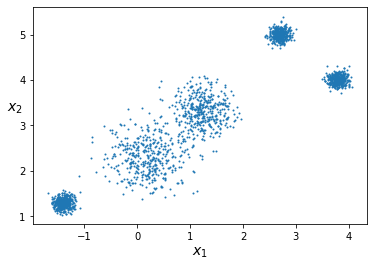

In [3]:
plot_clusters(X)

We've mimicked a bunch of clustered data in 2D. Each cluster has its own label in y, but for unsupervised learning, we might not have this assignment at all... we're just trying to separate the clusters ourselves without prior knowledge that they may be different.

## K-means clustering
A super common approach to clustering is called K-means clustering. In k means, centroids are randomly assigned to the dataset, and iteratively updated based on how close they are to the center of mass to the datapoints closest to them. 

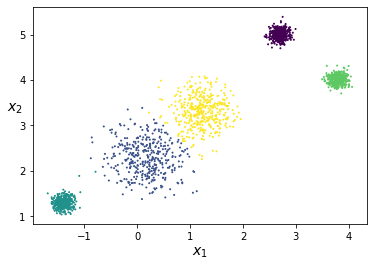

In [4]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

plot_clusters(X, y_pred)

Using K Means, we've predicted the 5 clusters, and based on the visual, we did a pretty decent job. Let's plot the decision boundaries which our algorithm found. Each white dot represents the cluster centroid which the kmeans algorithm found.

In [5]:
from mlxtend.plotting import plot_decision_regions
def plot_kmeans_regions(X, y, clf):
  plt.figure(figsize=(8,6))
  plot_decision_regions(X=X, y=y, clf=clf)
  plt.scatter(clf.cluster_centers_[:,0], clf.cluster_centers_[:,1], marker='o', s=30, linewidths=6, c='w')
  plt.xlabel('$x_1$', fontsize=14)
  plt.ylabel('$x_2$', fontsize=14, rotation=0)

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


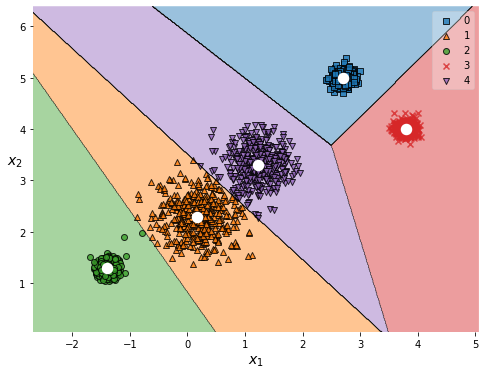

In [6]:
plot_kmeans_regions(X, y_pred, kmeans)

The kmeans algorithm can assign a cluster to each individual point, or it can do **soft clustering**, where the distance to each centroid is given for each point in X. This is done with the transform method.

In [7]:
kmeans.transform(X[:5,:])

array([[0.26940701, 3.92289197, 5.7142865 , 1.65821541, 2.46767478],
       [2.77852957, 0.95692346, 2.80465515, 3.07348496, 0.54074823],
       [2.94378305, 0.77453237, 2.61945662, 3.26366612, 0.69773243],
       [0.1546462 , 3.73683151, 5.55593658, 1.32714341, 2.27173102],
       [3.84696693, 0.23474384, 1.67677072, 4.20942164, 1.61910995]])

##Mini-batch K-Means
When datasets get really big and won't fit into memory, we can use something classed mini-batch k means. This processes our data in parts, or batches, moving the centroids more slowly. However, the process actually speeds up the algorithm by a factor of three or four.

In [8]:
from sklearn.cluster import MiniBatchKMeans
minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [9]:
print("minibatch speed:")
%timeit minibatch_kmeans.fit(X)
print("\nregular kmeans speed:")
%timeit kmeans.fit(X)

minibatch speed:
10 loops, best of 3: 25.5 ms per loop

regular kmeans speed:
10 loops, best of 3: 36.3 ms per loop


the `%timeit` snippet is called an ipython magic command, and allows us to time how long a process takes to run. it runs the command a bunch of times and gives us an average of the best runtimes. Or something. Anyway, in this case, minibatch works faster.

## Optimizing the amount of clusters
A difficulty in running the k means algorithm is that you need to predefine the right amount of clusters. that is, how many groups your data should be sorted into. That's not always so easy, especially in a multidimentional dataset where you can't easily visualize or even conceptualize the information in front of you. So what do we do? Give up. Wait no, we find another algorithm to help out. One thing to use here is the silhouette score. The silhouette score is equal to $(b-a)/max(a,b)$, where a is the mean distance to the other instances in the same cluster, and b is the mean distance to instances of the next closest cluster.

In [10]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.7614582452359432

In [11]:
scores = []
for i in range(2,10):
  kmeans_temp = MiniBatchKMeans(n_clusters=i)
  scores.append(silhouette_score(X, kmeans_temp.fit_predict(X)))

Text(0.5, 0, 'k')

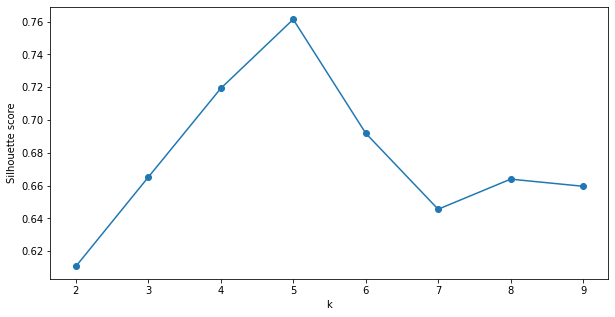

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(2,10),scores, marker='o')
plt.ylabel('Silhouette score')
plt.xlabel('k')

Clearly, the silhouette score is highest for k=5, which is how many clustered we made. This isn't always so clear, so let's look at another way to identify the optimal cluster amount. We can plot what's referred to as a silhouette diagram, where each knife shape is given per cluster. The hieght of the shape indicates the number of instances in the cluster, while the width represents the sorted silhouette coefficients of the instances. Wider is better, as this gives us a higher silhouette score. Sharper knives are less heterogeneous.

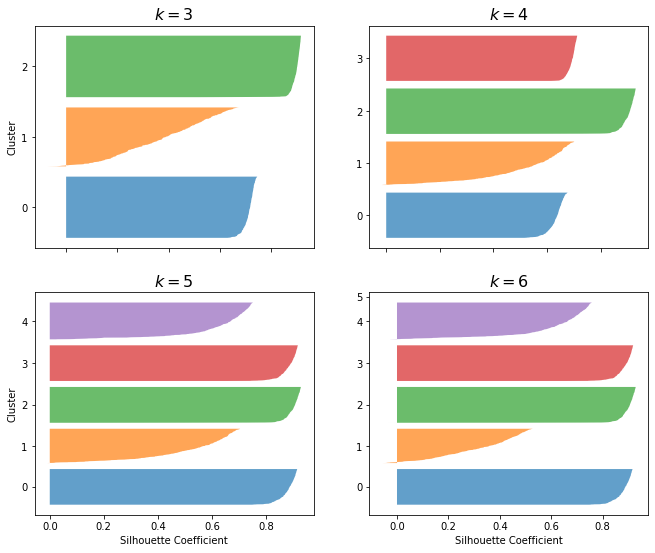

In [13]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter


plt.figure(figsize=(11,9))
for k in [3,4,5,6]:
  plt.subplot(2,2,k-2) 
  kmeans_temp = MiniBatchKMeans(n_clusters=k)
  silhouette_coefficients = silhouette_samples(X, kmeans_temp.fit_predict(X))

  padding = len(X) // 30
  pos = padding
  ticks = []
  for i in range(k):
      coeffs = silhouette_coefficients[y_pred == i]
      coeffs.sort()

      plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, alpha=0.7)
      ticks.append(pos + len(coeffs) // 2)
      pos += len(coeffs) + padding

  plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
  plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
  if k in (3, 5):
      plt.ylabel("Cluster")
  
  if k in (5, 6):
      plt.xlabel("Silhouette Coefficient")
  else:
      plt.tick_params(labelbottom=False)

  plt.title("$k={}$".format(k), fontsize=16)

In this particular case, the model doesn't want to make any more that 5 clusters, (it seems that cluster #6 is just empty). That being said, k=6 still has worse looking clusters relative to k=5. 

## Bad clustering
Sometimes our clusters aren't uniform the way we'd like, which would result in problems with how k-means ends up assigning them. Here's an example...

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


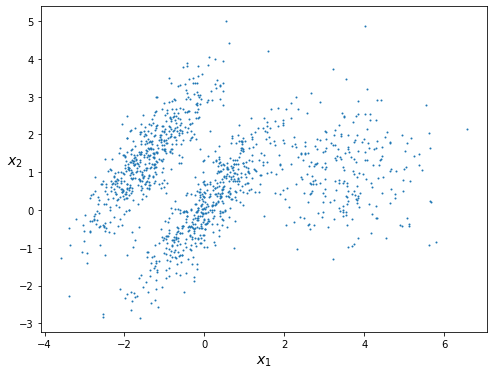

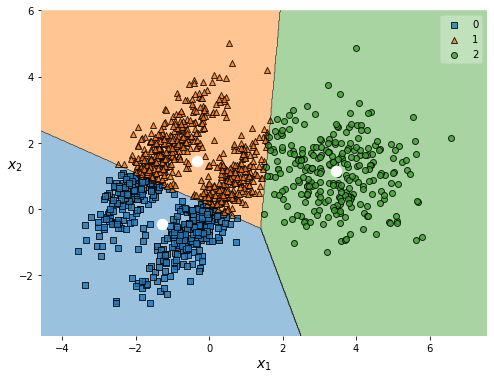

In [14]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=RANDOM_SEED)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]
plt.figure(figsize=(8,6))
plot_clusters(X)


kmeans_bad = MiniBatchKMeans(n_clusters=3, random_state=RANDOM_SEED)
y_pred = kmeans_bad.fit_predict(X)

plot_kmeans_regions(X, y_pred, kmeans_bad)


That clustering ain't got no alibi if you know what I mean. K means IS SOMETIMES ABLE to get this right, but it's a particularly difficult problem due to the shape of the clusters. We can scale the features to try and improve performance, but that doesn't always work.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


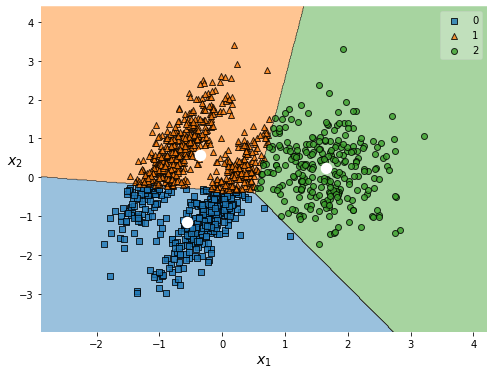

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = MiniBatchKMeans(n_clusters=3, random_state=RANDOM_SEED)
y_pred = kmeans.fit_predict(X_scaled)

plot_kmeans_regions(X_scaled, y_pred, kmeans)

Let's move on from k-means then... perhaps we'll solve this problem? (yes). 

##Gaussian Mixture Model
A gaussian micture model is a probabalistic model which assumes the instances were generated from a mixture of several gaussian distributions with unknown parameters. Once again, we need to know the amount of clusters, k.

/usr/local/lib/python3.6/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


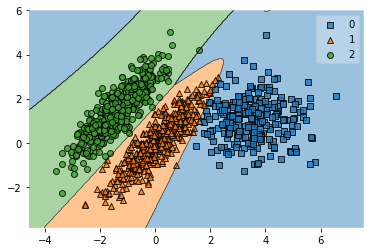

In [16]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
y_pred = gm.fit_predict(X)

plot_decision_regions(X, y_pred, gm)

The gaussian mixture model certainly performed better on our elongated dataset. It's also possible to estimate probability that an instance will fall within a particular region. This code creates a meshgrid of values to plot contours estimating the probability of a value falling within the area. 

In [17]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [19]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

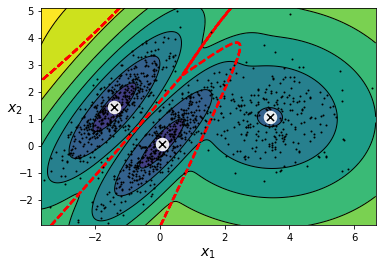

In [20]:
plot_gaussian_mixture(gm, X)

Depending on the particulars of the dataset, this technique might have a difficult time finding a solution, in which case we may want to limit the number of the parameters the algorithm has to learn. We can do this by changing the **covariance_type** property from full, the default, to *spherical*, *diag*, or *tied*. Here's an example of a spherical distribution... 

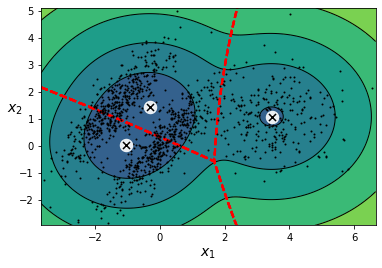

In [21]:
gm = GaussianMixture(n_components=3, n_init=10, covariance_type='spherical')
gm.fit(X)
plot_gaussian_mixture(gm, X)


##Anomaly Detection
Gaussian mixtures are often used for anomaly detection - discovering outliers in data. This techinique is incredibly important in plenty of fields, a big one being fraud detection. Le't say you have a bunch of financial records, know there is some fraud going on, and need to figure out who's doing it. You don't have a training data set, and very few actual cases are fraudulent, compared to the massive amount of non-fraudulent datapoints.

Looking at the graphs above, you might have a guess at how to find anomalies here... just look at where the low density regions are, and any datapoints associated with them might be worth examining.


In [22]:
anomaly_threshold = 4 # percentage of anomalies expected in dataset

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, anomaly_threshold)
anomalies = X[densities < density_threshold]

Text(0.5, 1.0, 'Anomalies outside of clusters')

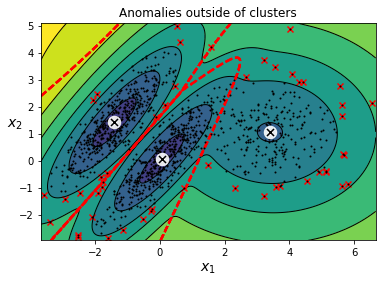

In [25]:
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:,0], anomalies[:,1], color='r', marker='x')
plt.title('Anomalies outside of clusters')

## Selecting cluster number with Gaussian Mixtures

Unlike K-means, we can't use inertia or silhouette scores. Two criteria which can be used here are the baesian information criterion, BIC, or Akaike information criterion, AIC. These both penalize models that make too many clusters, and reward models which fit data well. Let's take a looksypoo.

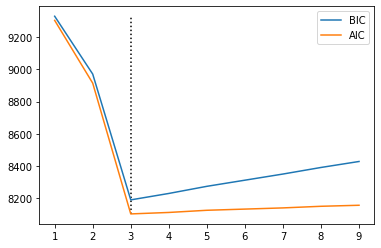

In [35]:
bic, aic = [], []
x = list(range(1,10))
for k in x:
  gm = GaussianMixture(n_components=k, n_init=10)
  gm.fit(X)
  bic.append(gm.bic(X))
  aic.append(gm.aic(X))

plt.plot(x, bic, label='BIC')
plt.plot(x, aic, label='AIC')
plt.legend()
plt.vlines(x[np.argmin(bic)], np.min([bic,aic]), np.max([bic,aic]), linestyles='dotted')

In this example, we ran through all the possibilities, and see the lowest BIC and AIC scores resting at k=3. Just as we expected.

There's another technique, called bayesian gaussian mixture models, which allows us to roughly estimate the n_components (k) without having to run this loop. Here, we set the n_components to a value higher than what we think is the accurate estimate.

In [40]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X)

np.round(bgm.weights_,2)

array([0.4 , 0.21, 0.39, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

Instead of running through all the possibilities, bgm found that only three clusters are needed, the rest of the clusters having much smaller weights.